In [12]:
%pip install pyspark
%pip install findspark
%pip install spark-nlp
%pip install matplotlib
%pip install seaborn



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
# %%
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import col , sum as sum_func , when ,mean as _mean, stddev as _stddev, col , collect_list
from pyspark.sql import functions as F
from pyspark.sql.types import *
from IPython.display import display
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import sparknlp

import numpy as np
from numpy import allclose
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import RandomForestClassifier , DecisionTreeClassifier , GBTClassifier
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

In [2]:
# %%
import findspark
findspark.init()
findspark.find()

'/anaconda/envs/jupyter_env/lib/python3.8/site-packages/pyspark'

# Data Cleaning

In [3]:
# %%
# Create a SparkSession

# Create a SparkSession
spark = SparkSession.builder \
    .appName("MyApp") \
    .config("spark.executor.memory", "32g") \
    .config("spark.driver.memory", "32g") \
    .getOrCreate()

24/05/12 17:06:22 WARN Utils: Your hostname, bdsongscompute2 resolves to a loopback address: 127.0.0.1; using 10.0.0.4 instead (on interface eth0)
24/05/12 17:06:22 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/12 17:06:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# %%
audio_features_df = spark.read.csv("/kaggle/input/10-m-beatport-tracks-spotify-audio-features/audio_features.csv", header=True, inferSchema=True)
genres_df = spark.read.csv("/kaggle/input/10-m-beatport-tracks-spotify-audio-features/bp_genre.csv", header=True, inferSchema=True)
track_genre_df = spark.read.csv("/kaggle/input/10-m-beatport-tracks-spotify-audio-features/bp_track.csv", header=True, inferSchema=True)
# %%
# 3. Display schema of DataFrames. 
audio_features_df.printSchema()
genres_df.printSchema()
track_genre_df.printSchema()


AnalysisException: [PATH_NOT_FOUND] Path does not exist: file:/kaggle/input/10-m-beatport-tracks-spotify-audio-features/audio_features.csv.

In [ ]:
# %%
# clean dataframes

# remove unnecessary columns 
audio_features_df = audio_features_df.drop("updated_on")
audio_features_df = audio_features_df.dropDuplicates(subset=["isrc"])
genres_df = genres_df.drop("song_count" , "genre_url" , "updated_on" )
track_genre_df = track_genre_df.select("isrc" , "genre_id")

# Drop any NA in DFs
audio_features_df = audio_features_df.na.drop()
genres_df = genres_df.na.drop()
track_genre_df = track_genre_df.na.drop()

In [ ]:
features_genre_df = audio_features_df.join(track_genre_df, "isrc").drop("isrc")

features_genre_df = features_genre_df.join(genres_df, "genre_id").drop("genre_id").withColumnRenamed("genre_name" , "genre")

del audio_features_df
del genres_df
del track_genre_df

In [ ]:
features_genre_df = features_genre_df.na.drop()

features_genre_df.printSchema()

features_genre_df.show(5)

print(features_genre_df.count())

In [ ]:
features =[col_name for col_name, col_type in features_genre_df.dtypes if col_type.startswith('int') or col_type.startswith('float') or col_type.startswith('double')]


# make sure that all this features have numeric values

for feature in features:
    features_genre_df = features_genre_df.filter(
        col(feature).cast("float").isNotNull() | col(feature).cast("int").isNotNull() | col(feature).cast("double").isNotNull()
    )

In [ ]:
# %%
# show genres count
result = features_genre_df.groupBy("genre").count().sort("count" , ascending = False)
display(result.toPandas())

In [ ]:
# removing genres with less than 100k songs

filtered_result = result.filter(col("count") > 100000)
features_genre_df = features_genre_df.filter(features_genre_df.genre.isin(filtered_result.select("genre").toPandas()["genre"].tolist()))

In [ ]:
# %% [markdown]
# ## Correlation Matrix

# %%



# draw correlation matrix

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=features, outputCol=vector_col)
df_vector = assembler.transform(features_genre_df.select(features)).select(vector_col)

# get correlation matrix
corr_matrix_df = Correlation.corr(df_vector, vector_col).collect()[0][0].toArray()

plt.figure(figsize=(16, 5))
sns.heatmap(
    corr_matrix_df,
    xticklabels=features,
    yticklabels=features,
    cmap="YlGnBu",
    annot=True,
)

In [ ]:
# normalize features (danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo) using z-scoring

# Iterate over each feature
for feature in features:
    # Calculate mean and standard deviation
    stats = features_genre_df.select(
        _mean(col(feature)).alias("mean"),
        _stddev(col(feature)).alias("stddev")
    ).collect()
    mean = stats[0]["mean"]
    stddev = stats[0]["stddev"]

    # Z-score normalization
    features_genre_df = features_genre_df.withColumn(feature + "_zscore", (col(feature) - mean) / stddev)

    # Find the maximum absolute value after z-score normalization
    max_abs_value = features_genre_df.selectExpr(f"max(abs({feature}_zscore)) as max_abs_value").collect()[0]["max_abs_value"]

    # Scale the z-score normalized feature to lie between -1 and 1
    features_genre_df = features_genre_df.withColumn(feature + "_scaled", col(feature + "_zscore") / max_abs_value)

    # Drop intermediate z-score normalized column
    features_genre_df = features_genre_df.drop(feature + "_zscore")
    features_genre_df = features_genre_df.drop(feature)
    
    
    

In [ ]:
#load normalized data

features_genre_df = spark.read.csv("data22/", header=True)

In [ ]:
features_genre_df.printSchema()

In [ ]:
for feature in features:
    features_genre_df = features_genre_df.drop(feature)
    features_genre_df = features_genre_df.withColumnRenamed(feature+"_scaled" , feature )

features_genre_df.printSchema()

In [ ]:
features_genre_df.write.csv("data22" , header=True)

## Load scaled Features

In [4]:
#load scaled features
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType

features_genre_df = spark.read.csv("data/" , header=True)

In [6]:
### get subset of data

genres = features_genre_df.select("genre").distinct().rdd.flatMap(lambda x: x).collect()

In [8]:
selected_genres= ["Minimal / Deep Tech" , "Psy-Trance" ,  "Drum & Bass" , "Nu Disco / Disco" , "Trap / Wave" , "Electronica"   ]
# Sample 20,000 songs for each genre
sampled_dfs = []
for genre in selected_genres:
    genre_df = features_genre_df.filter(F.col("genre") == genre)
    sampled_genre_df = genre_df.sample(withReplacement=False, fraction=20000/genre_df.count(), seed=42)
    sampled_dfs.append(sampled_genre_df)


# Union all sampled DataFrames together
features_genre_df = sampled_dfs[0]  # Initialize with the first DataFrame
for df in sampled_dfs[1:]:
    features_genre_df = features_genre_df.unionAll(df)

# Show the resulting DataFrame
features_genre_df.show()


+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+--------------------+--------------------+--------------------+--------------------+
|              genre|        acousticness|        danceability|         duration_ms|              energy|    instrumentalness|                 key|            liveness|            loudness|             mode|         speechiness|               tempo|      time_signature|             valence|
+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+--------------------+--------------------+--------------------+--------------------+
|Minimal / Deep Tech| -0.1025092249131421| 0.27852392894952693|0.014715080567650496| 0.12532276046251076| 0.2819579902374377

In [9]:
features_genre_df.printSchema()

features = [col_name for col_name in features_genre_df.columns if col_name != "genre"]



for feature in features:
    features_genre_df = features_genre_df.withColumn(feature , col(feature).cast("double"))
    
features_genre_df.na.drop()
print(features_genre_df.count())
features_genre_df.printSchema()



root
 |-- genre: string (nullable = true)
 |-- acousticness: string (nullable = true)
 |-- danceability: string (nullable = true)
 |-- duration_ms: string (nullable = true)
 |-- energy: string (nullable = true)
 |-- instrumentalness: string (nullable = true)
 |-- key: string (nullable = true)
 |-- liveness: string (nullable = true)
 |-- loudness: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- speechiness: string (nullable = true)
 |-- tempo: string (nullable = true)
 |-- time_signature: string (nullable = true)
 |-- valence: string (nullable = true)

120676
root
 |-- genre: string (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- danceability: double (nullable = true)
 |-- duration_ms: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- key: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: double (nullable = true)
 |-- sp

## EDA

{(0.5843137254901961, 0.4235294117647059, 0.7058823529411765), (0.9333333333333333, 0.5215686274509804, 0.2901960784313726), (0.41568627450980394, 0.8, 0.39215686274509803), (0.2823529411764706, 0.47058823529411764, 0.8156862745098039), (0.5490196078431373, 0.3803921568627451, 0.23529411764705882), (0.8392156862745098, 0.37254901960784315, 0.37254901960784315)}


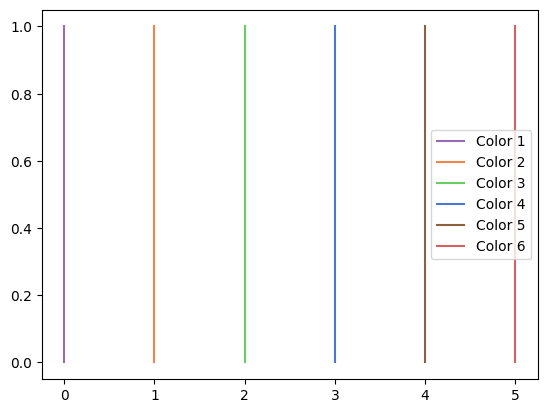

In [10]:

# Define the number of colors
num_colors = 6

# Create a list of different Seaborn color palettes
palettes = ['muted' , 'bright']

# Create a list to store the distinct colors
hex_colors = set()

# Generate colors from different palettes until we have enough distinct colors
for palette_name in palettes:
    palette = sns.color_palette(palette_name, num_colors)
    for color in palette:
        hex_colors.add(sns.palettes.color_palette([color])[0])
        if len(hex_colors) >= num_colors:
            break
    if len(hex_colors) >= num_colors:
        break

# Print the hexadecimal colors
print(hex_colors)

# Plot a sample using the colors
for i, color in enumerate(hex_colors):
    plt.plot([i, i], [0, 1], color=color, label=f'Color {i+1}')

plt.legend()
plt.show()

Exception in thread "serve RDD 981" java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:65)


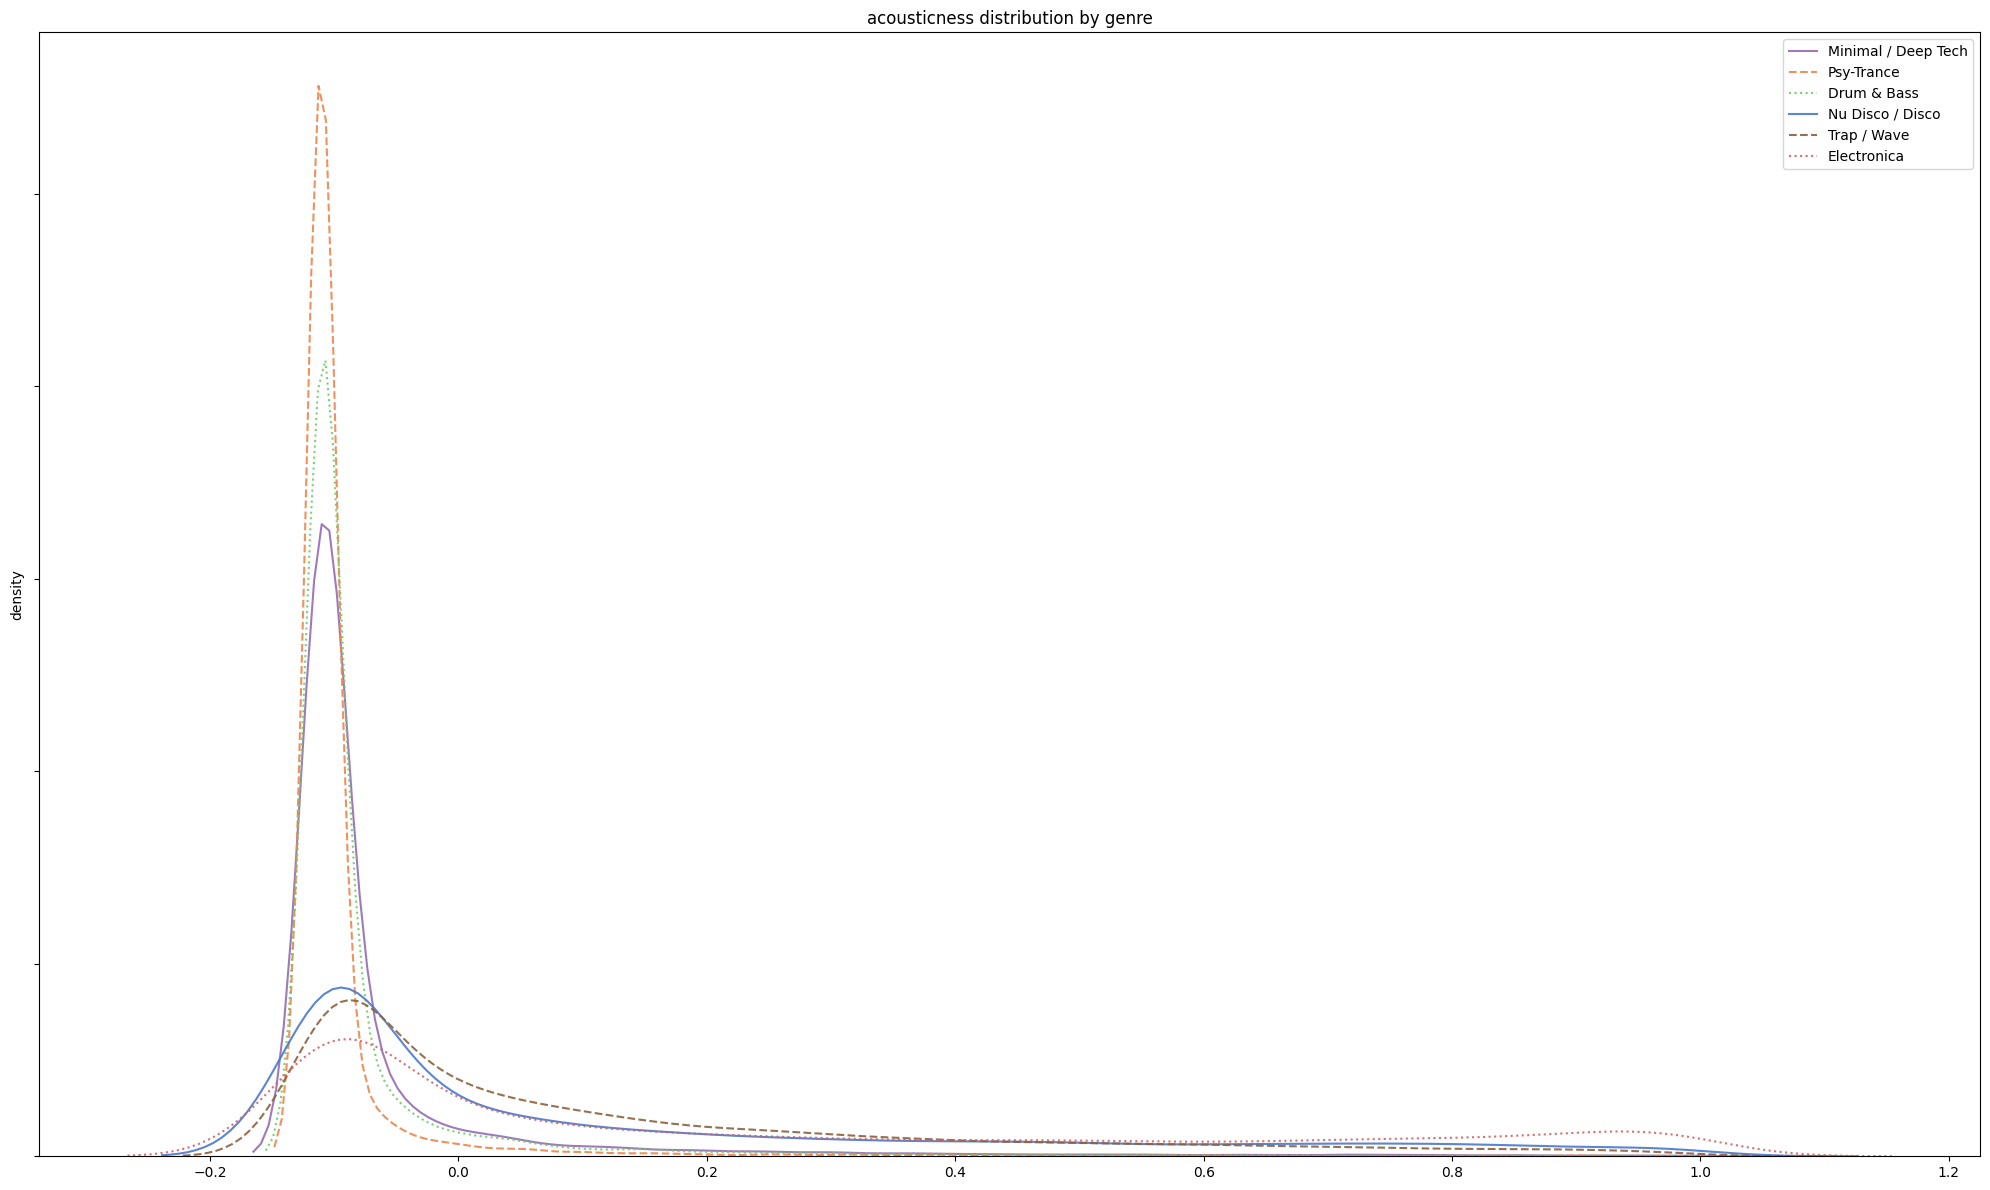

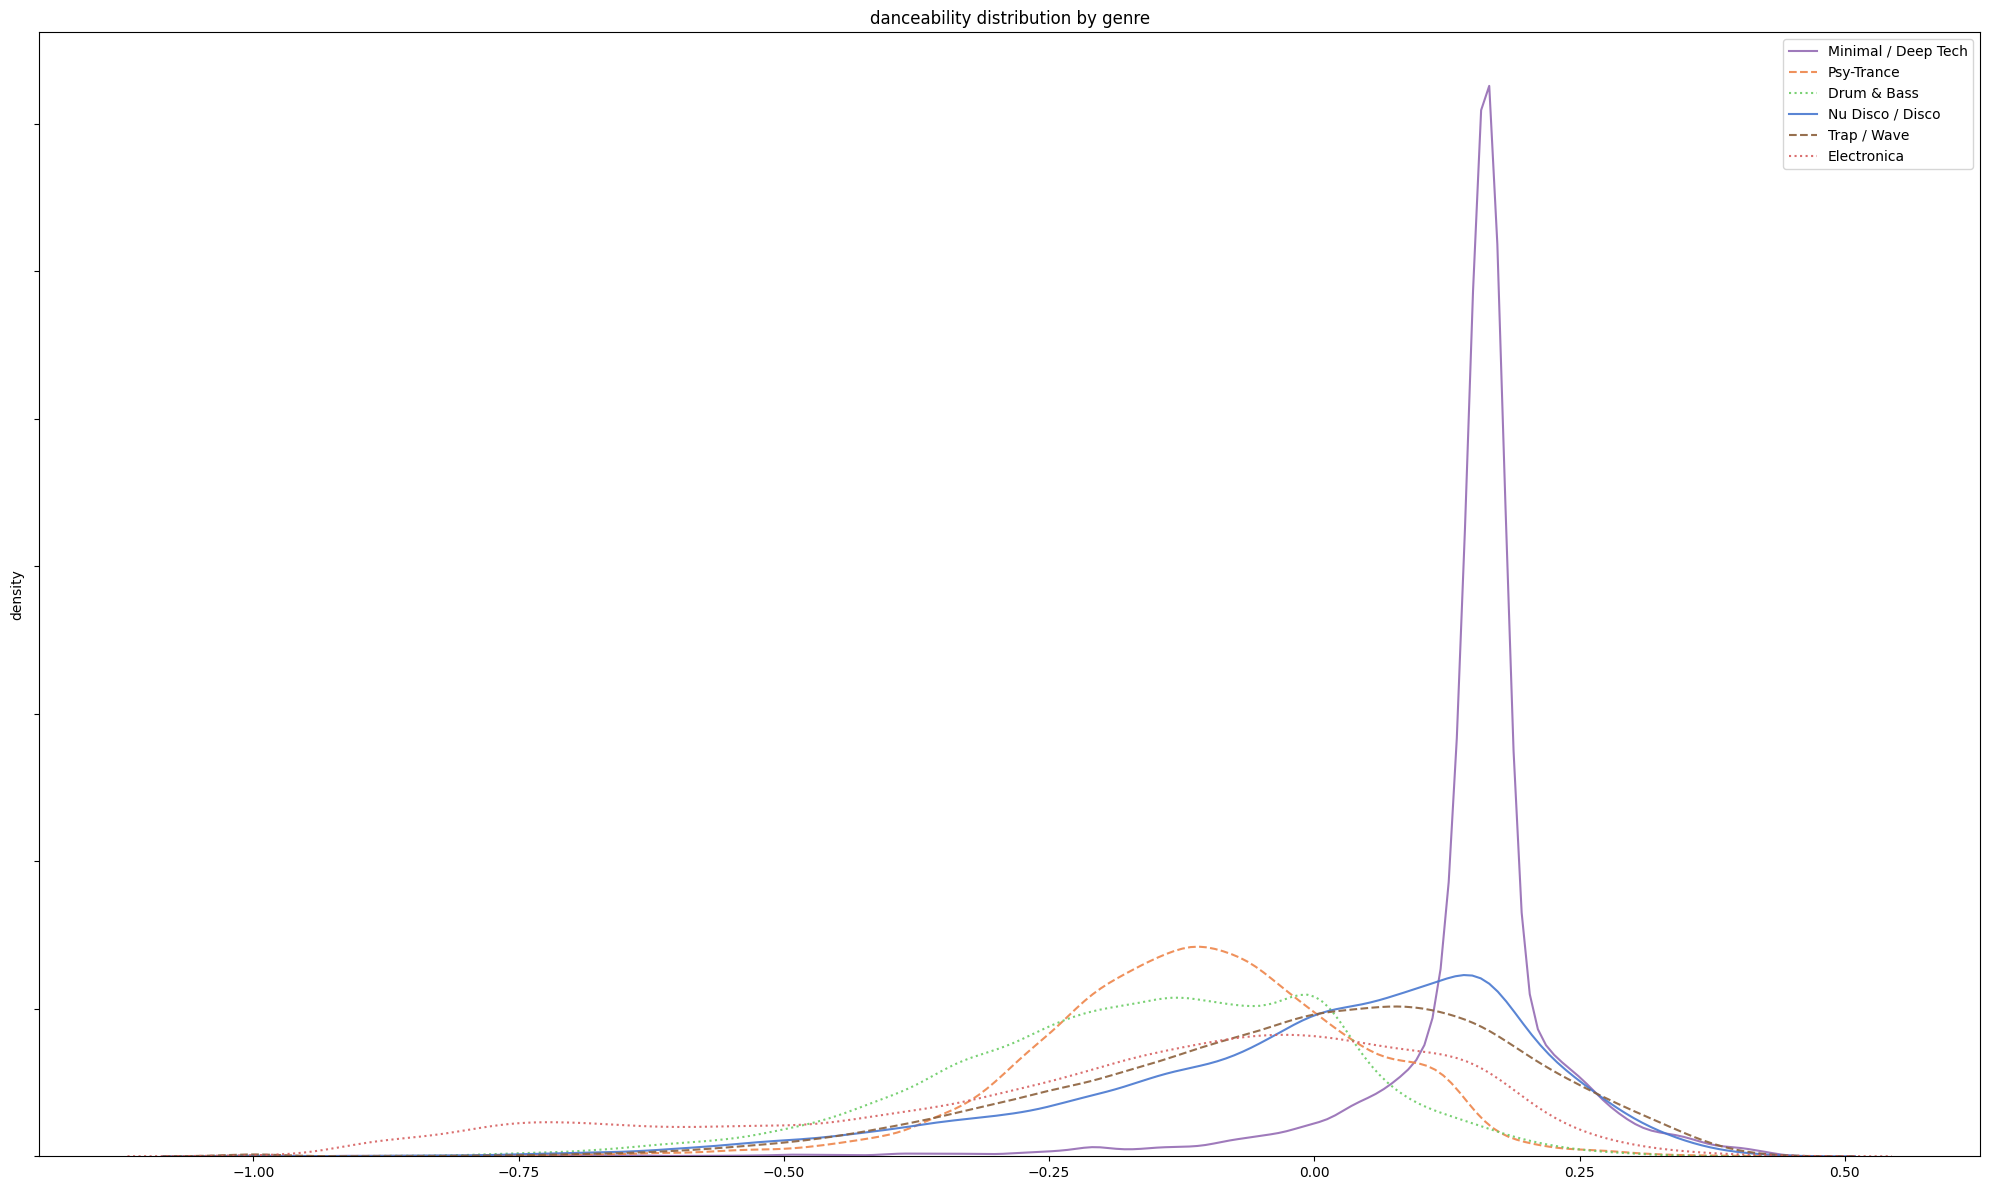

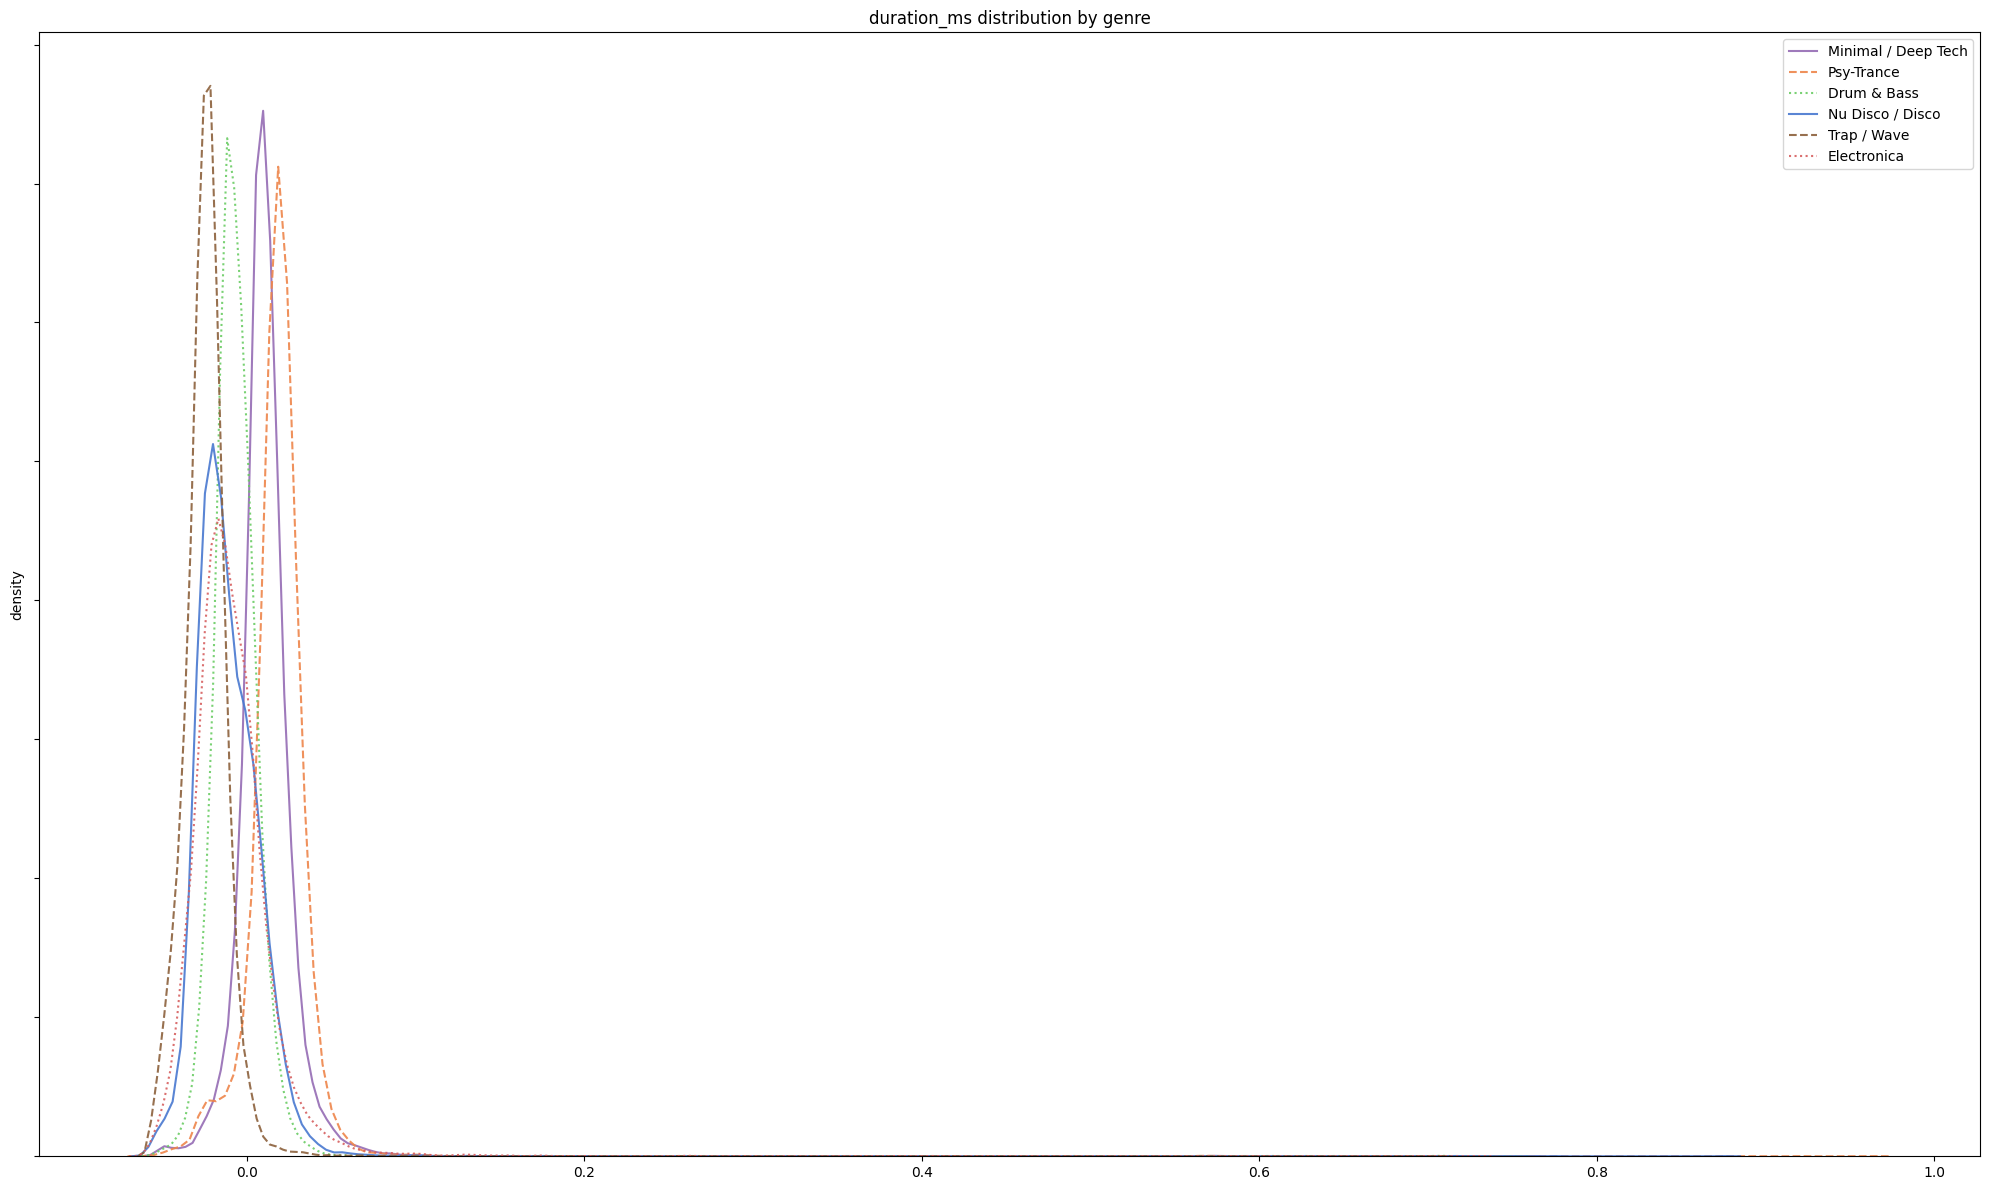

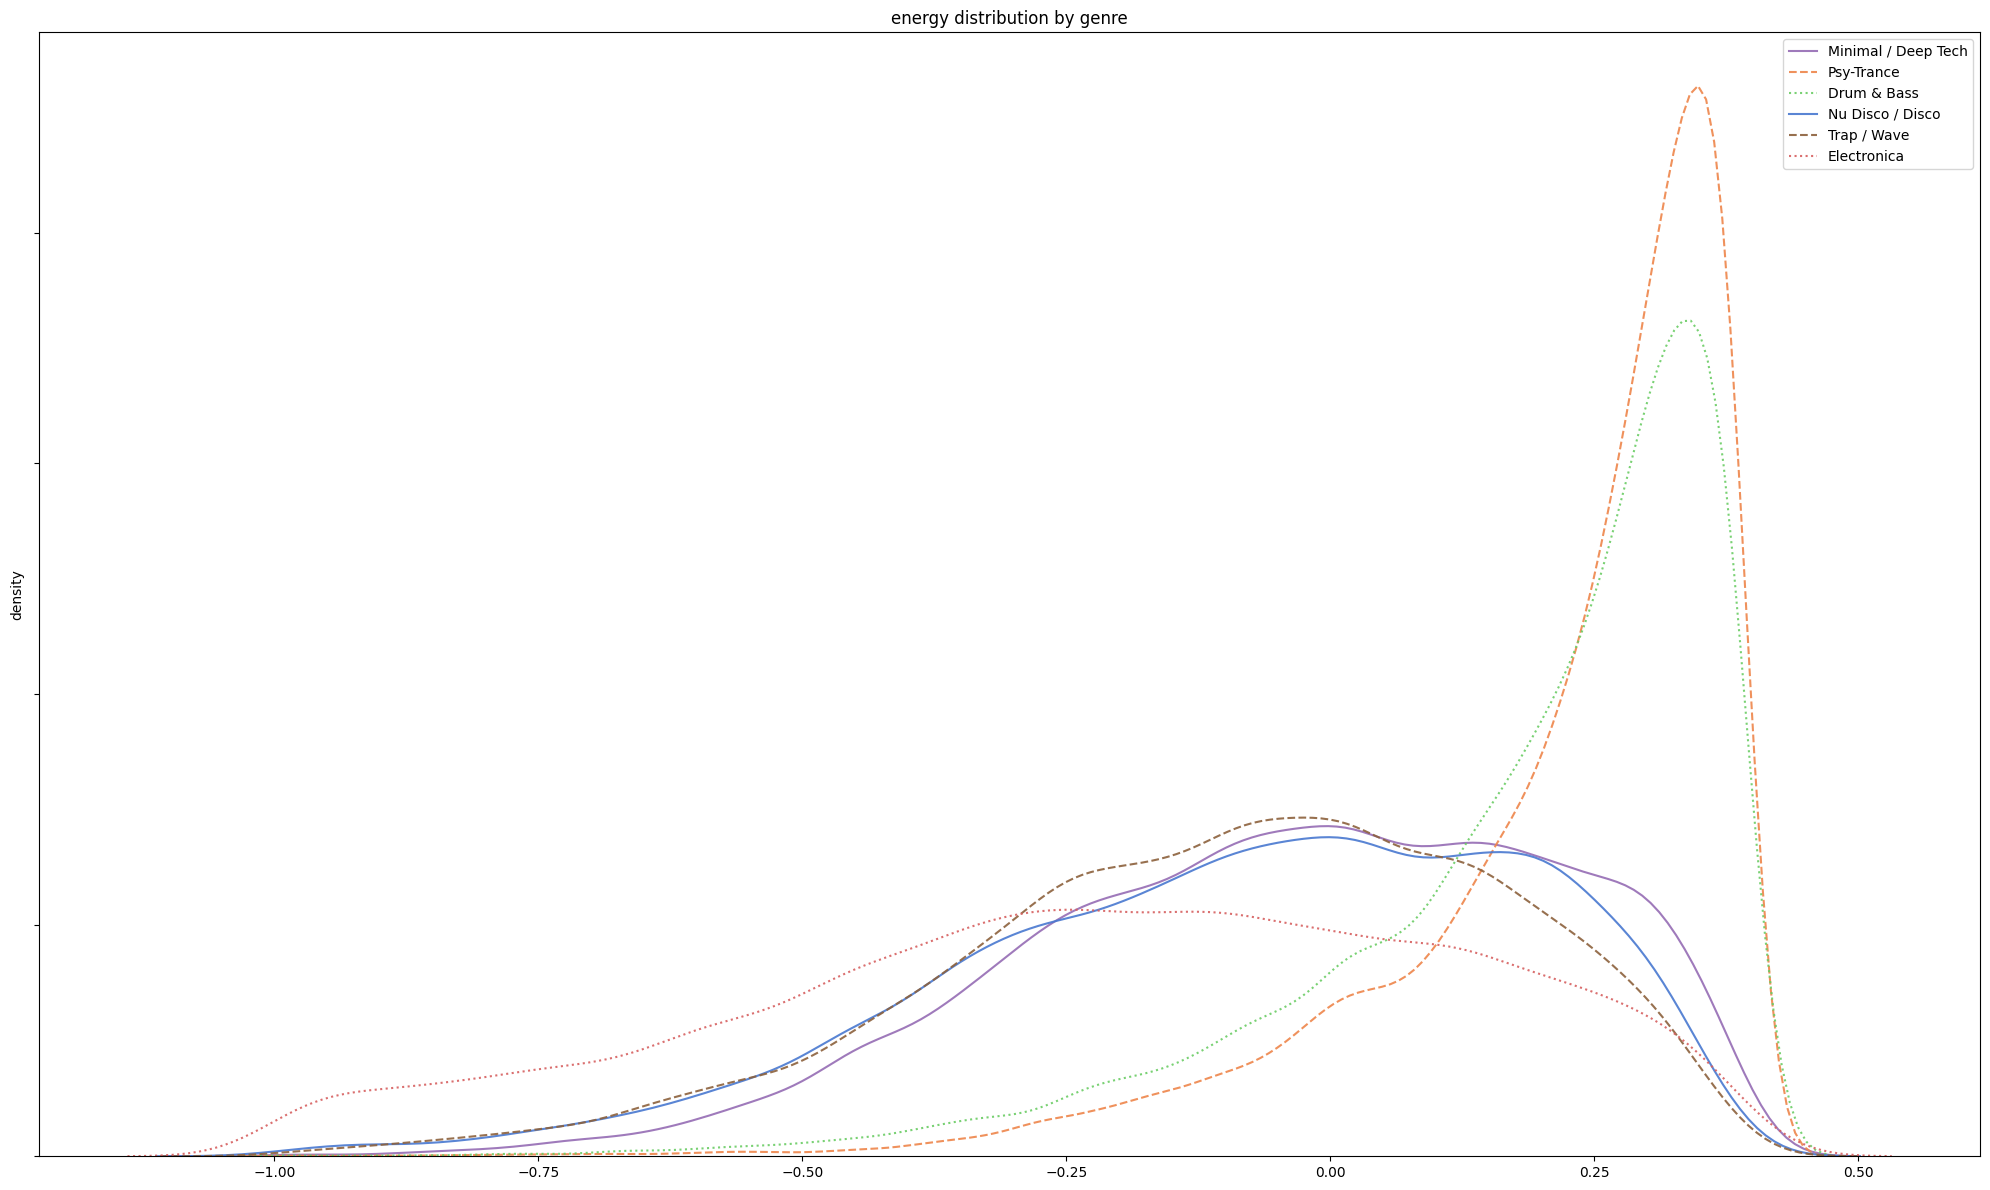

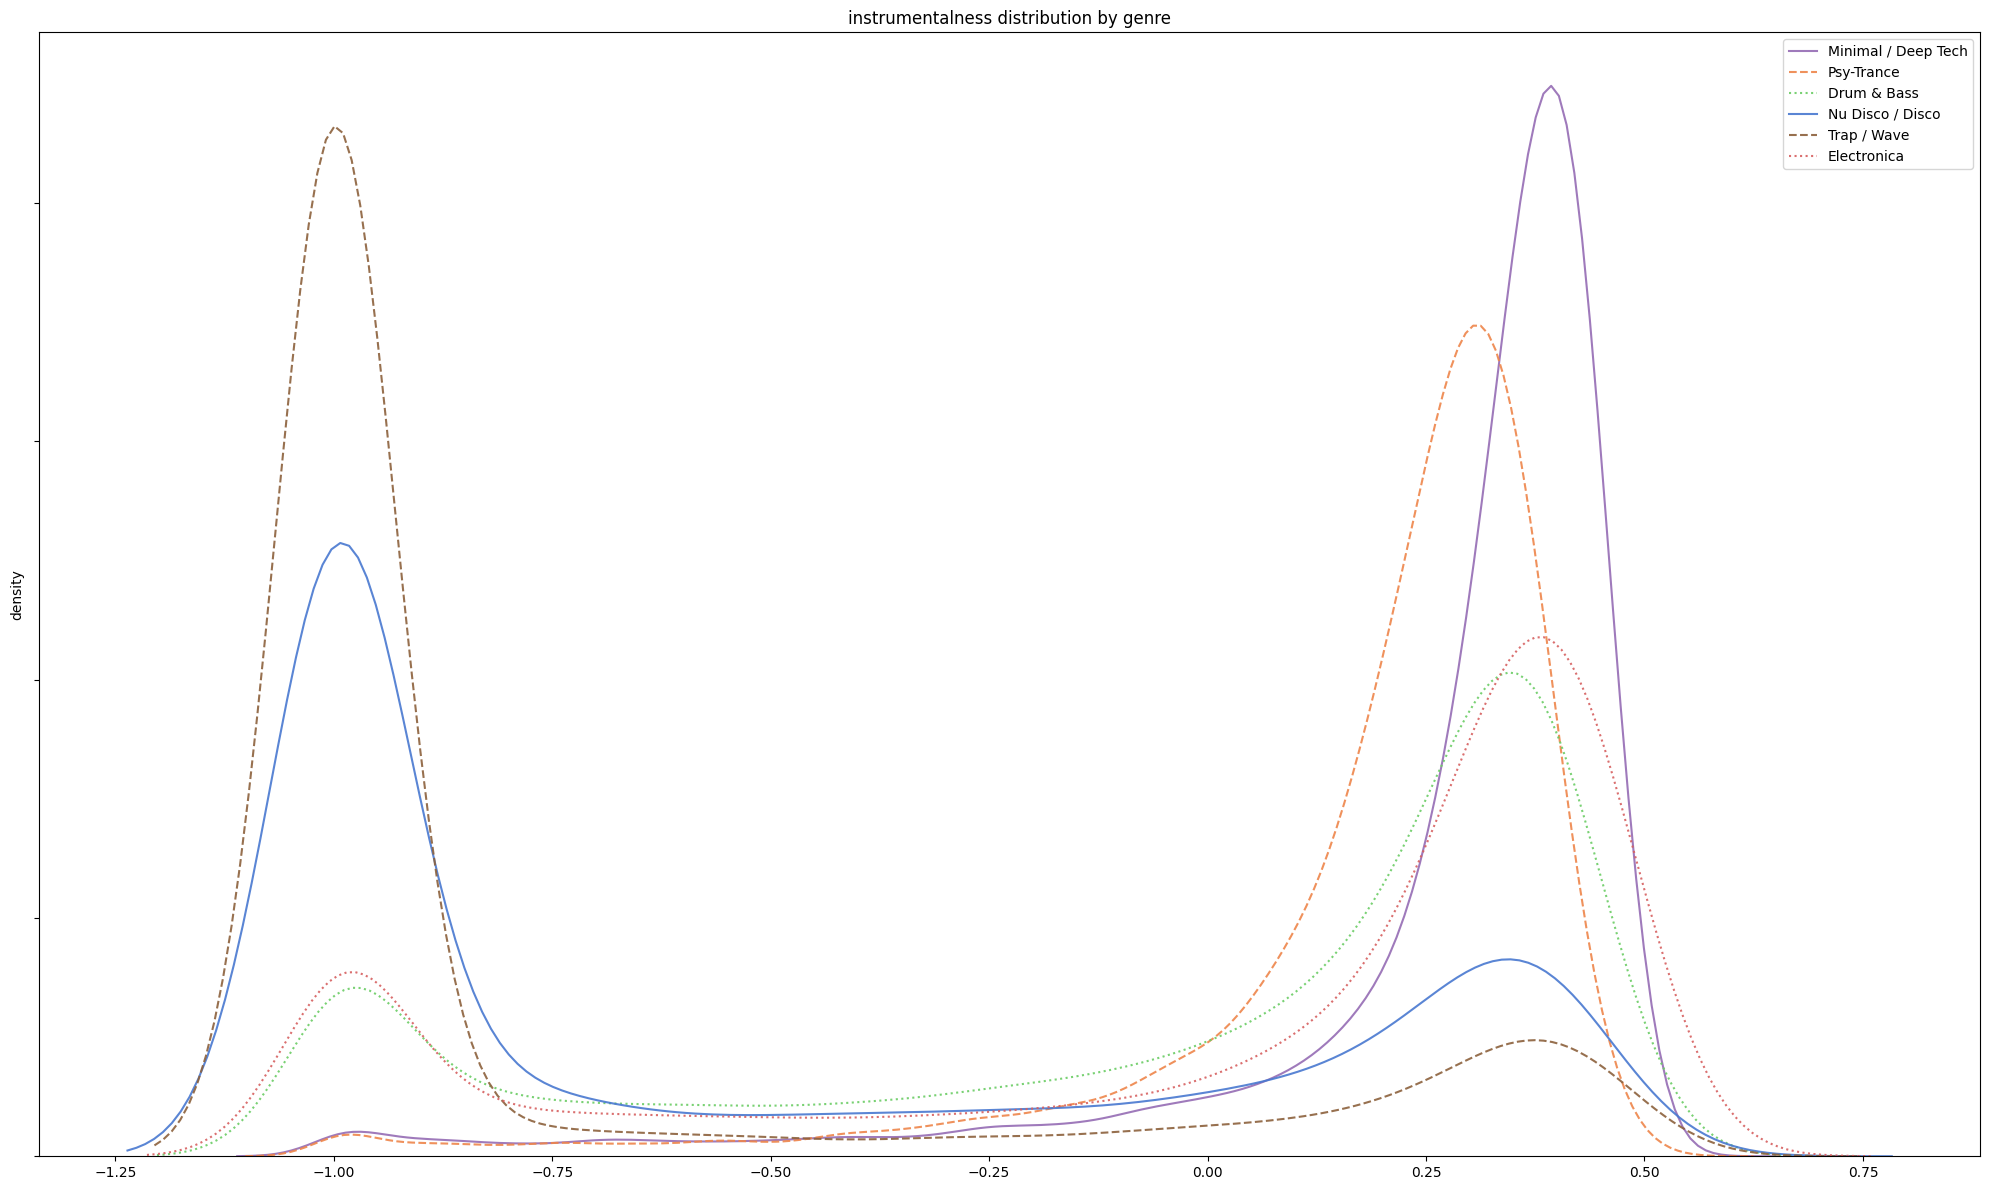

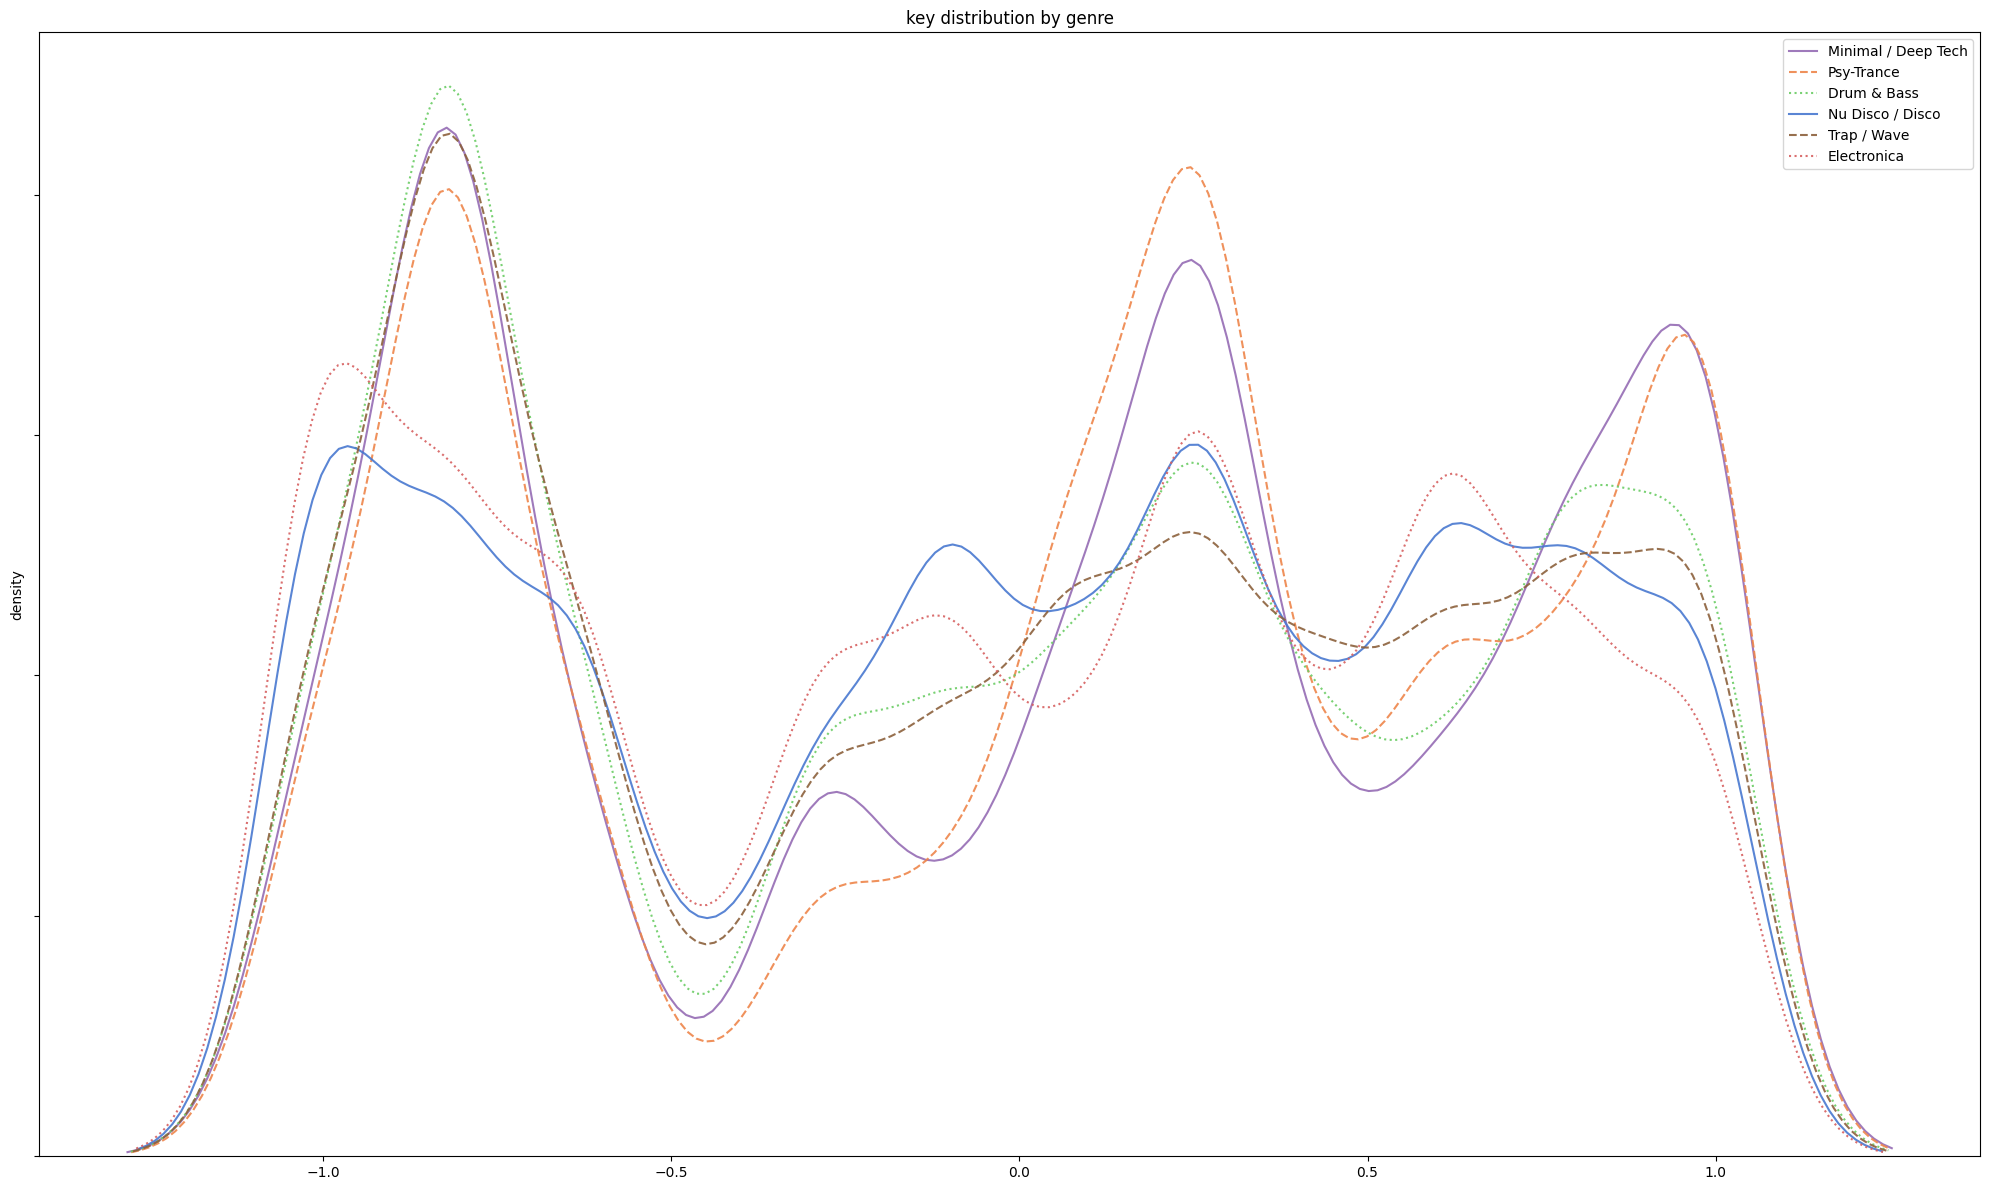

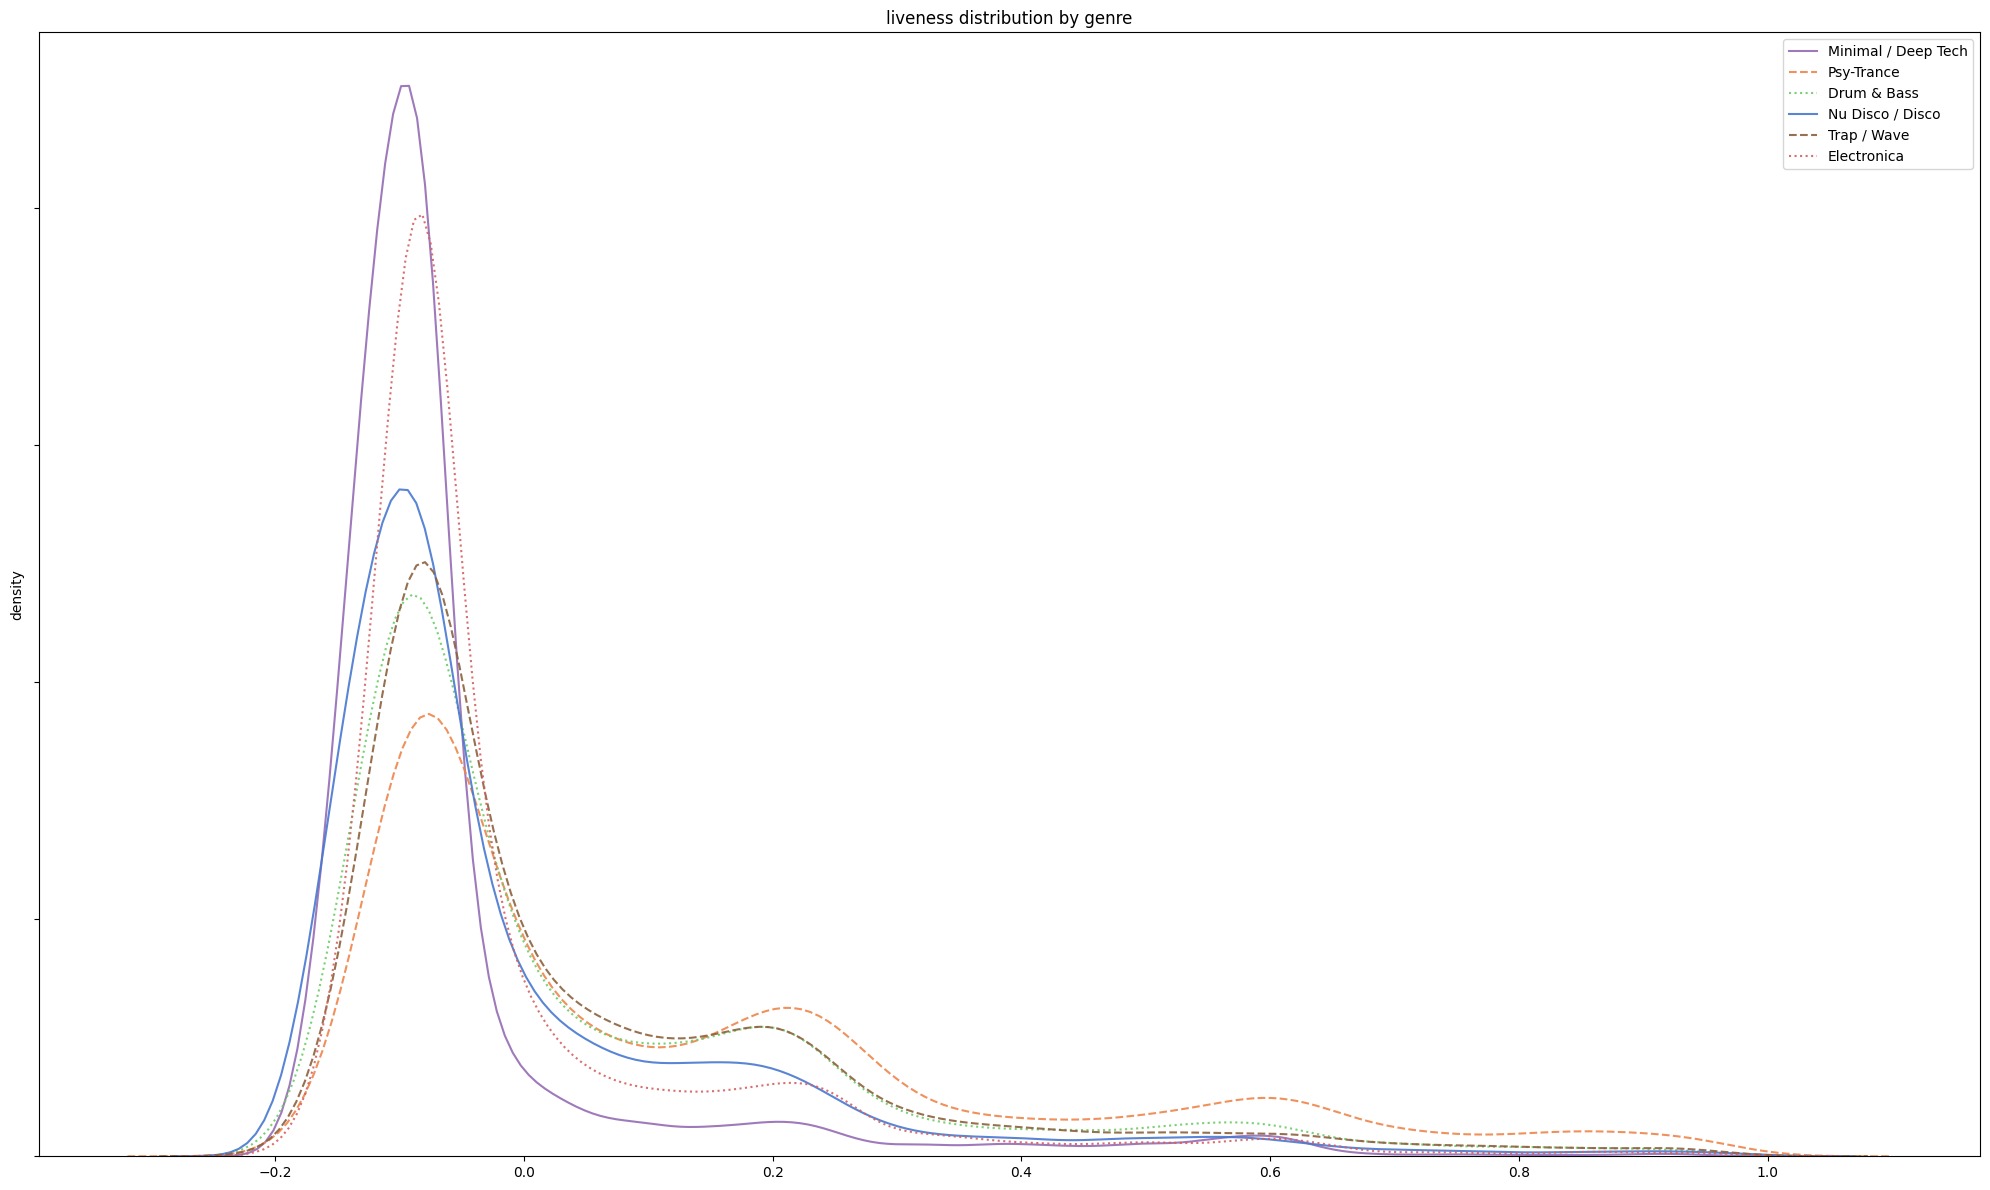

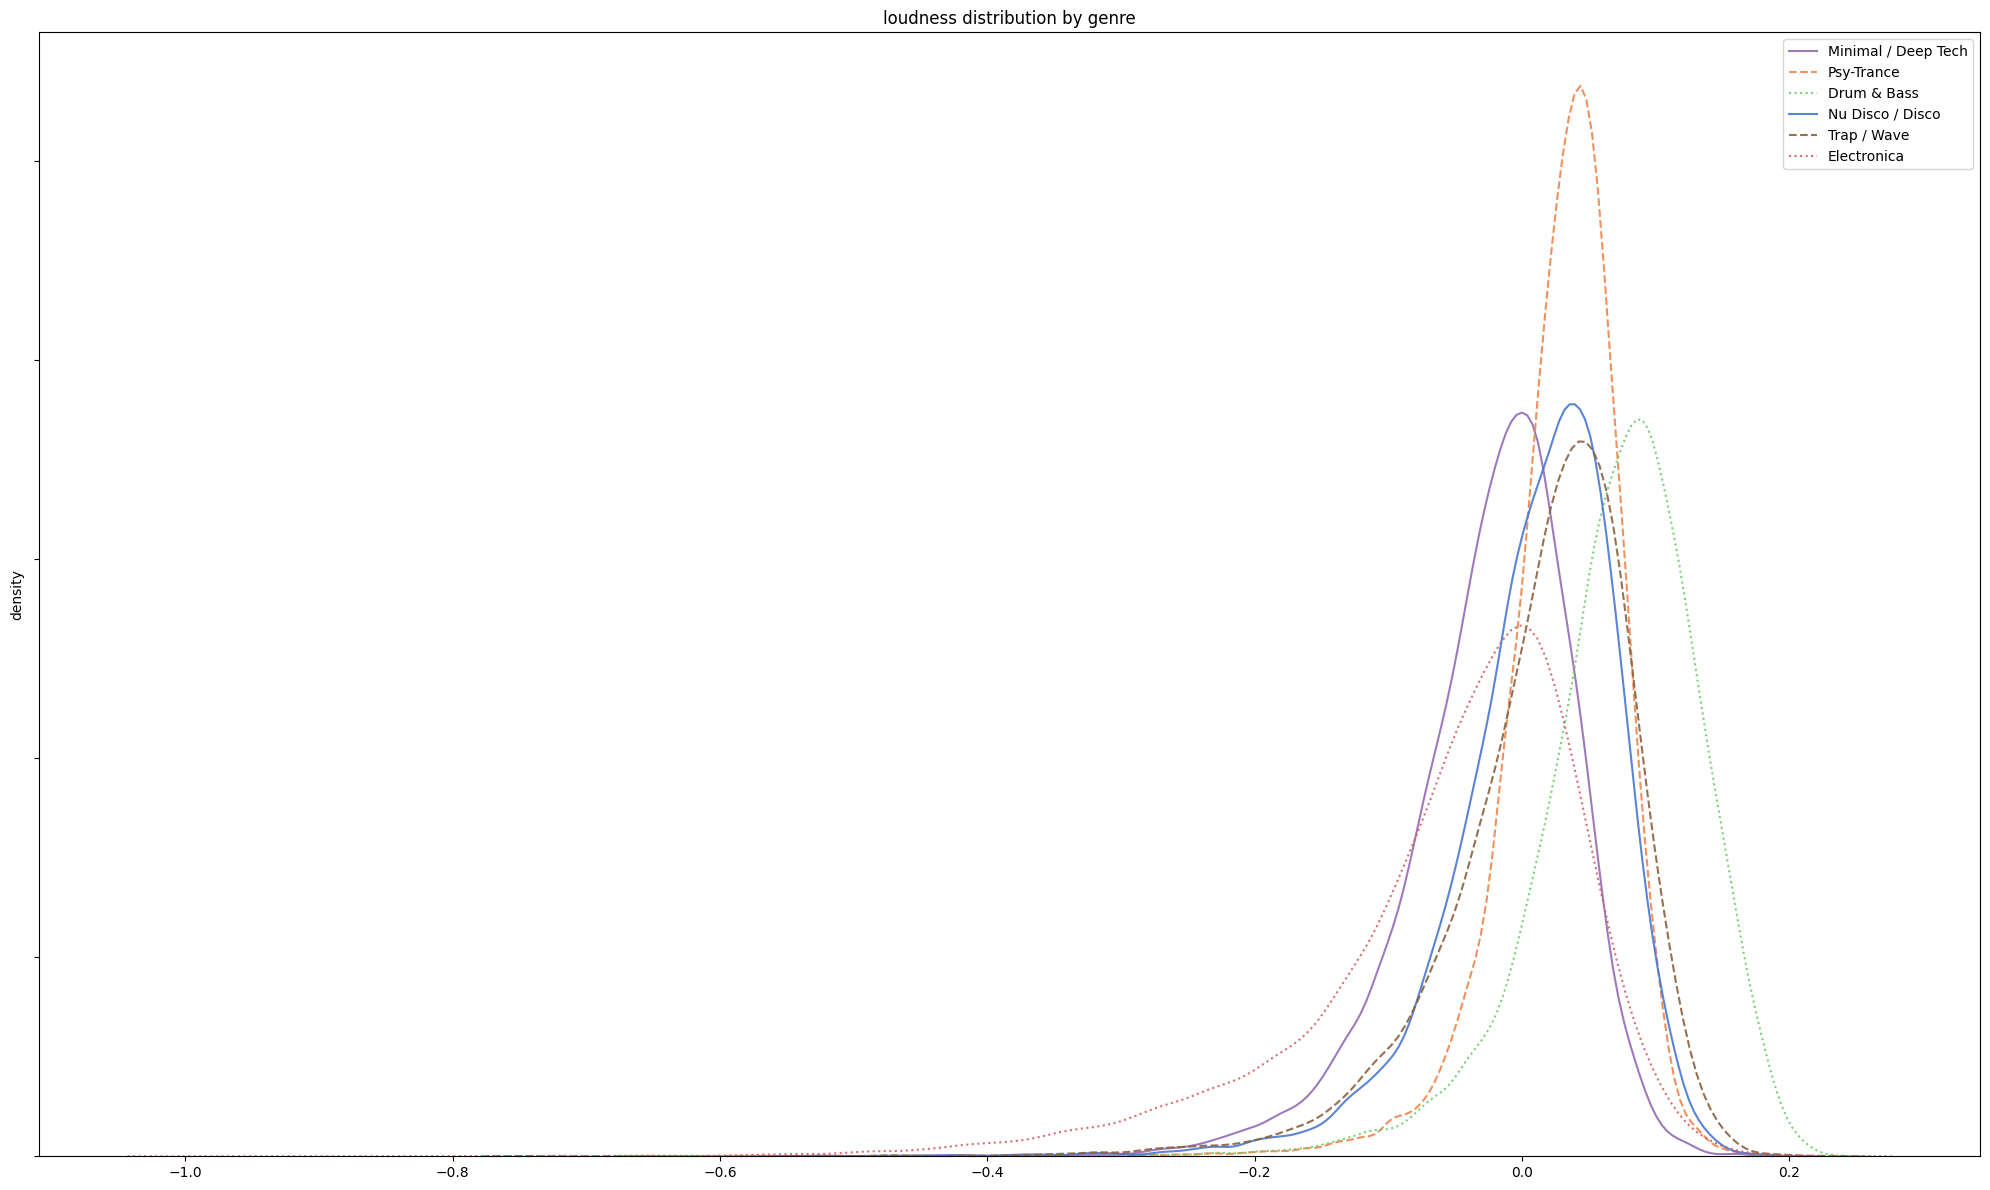

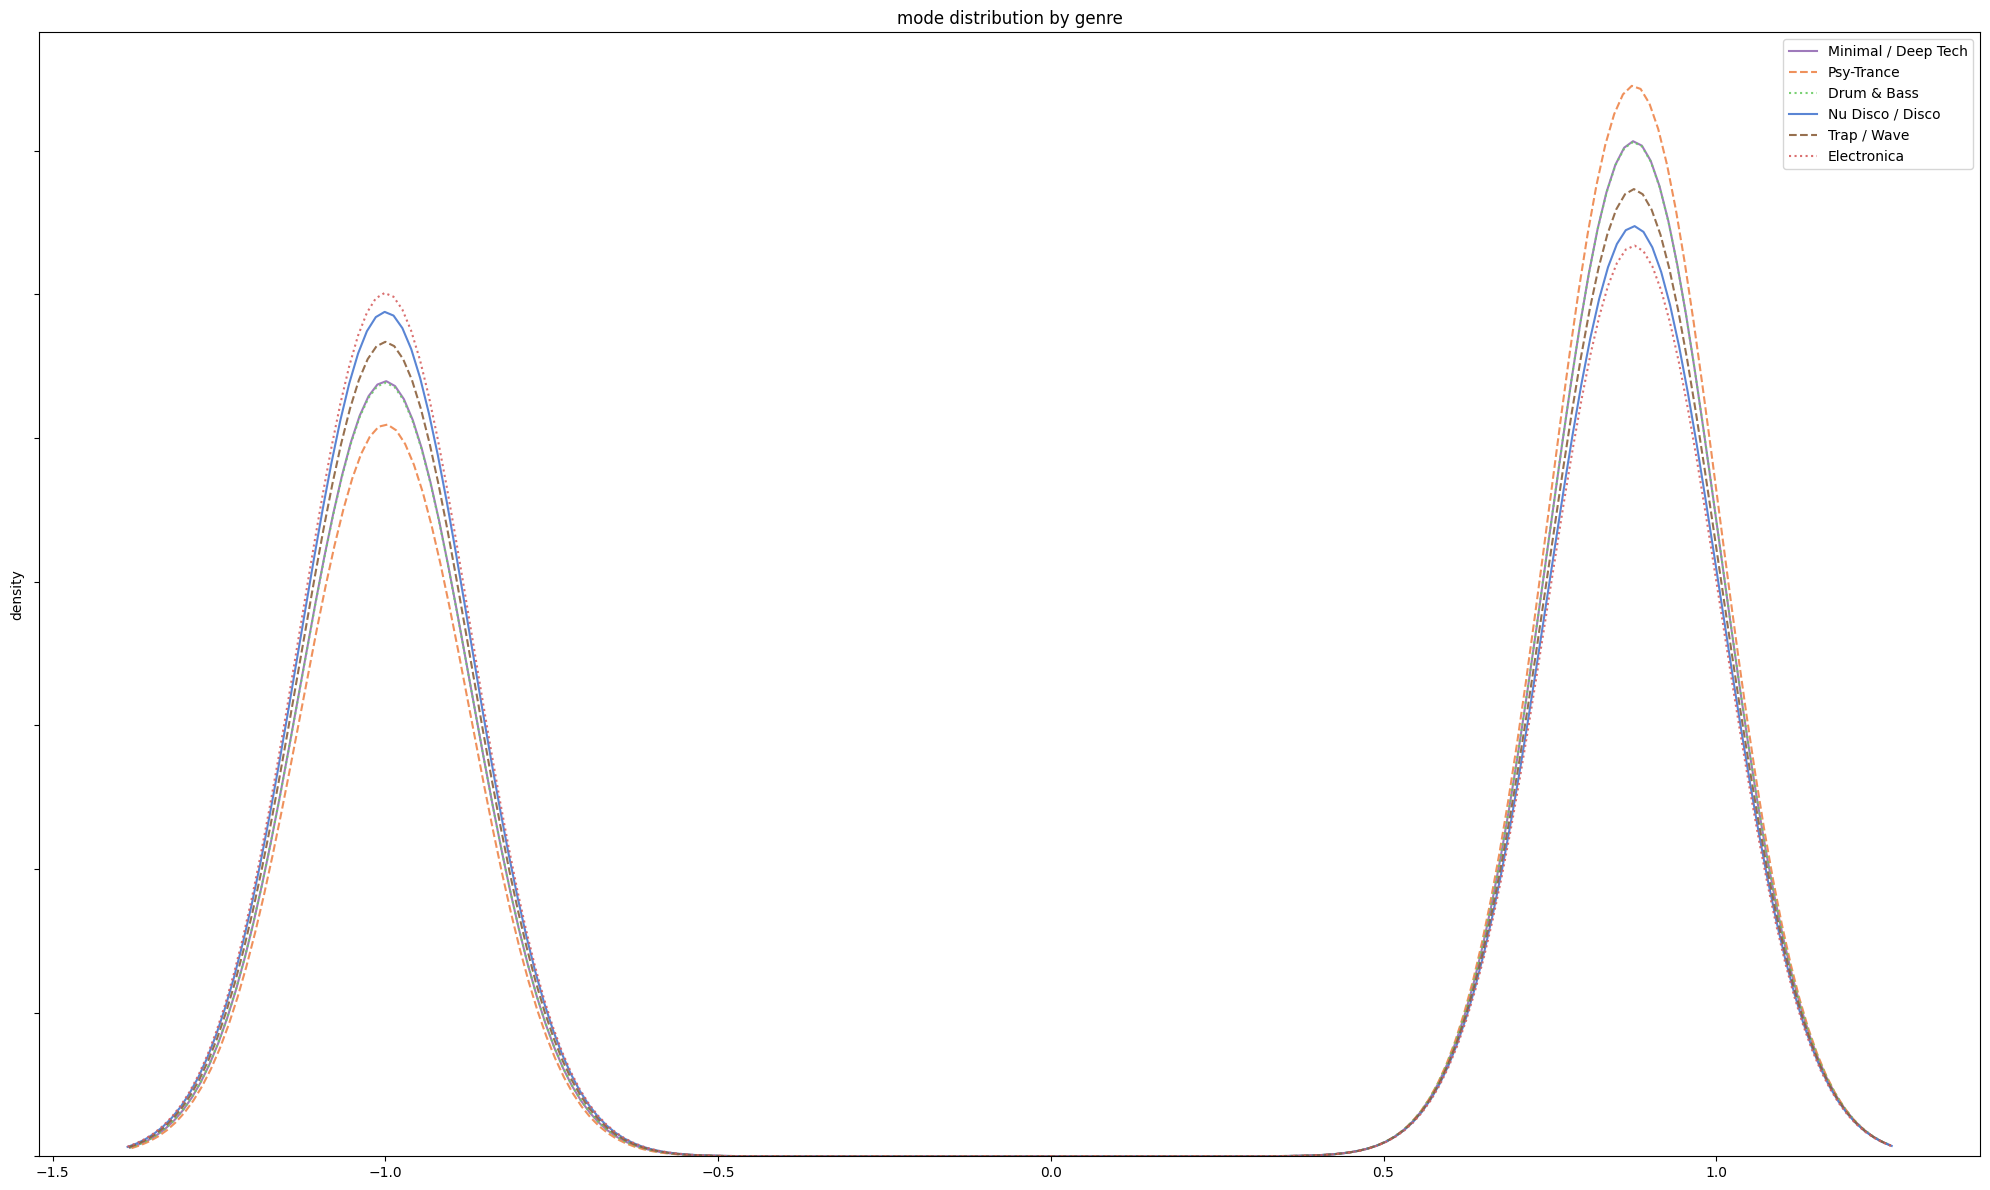

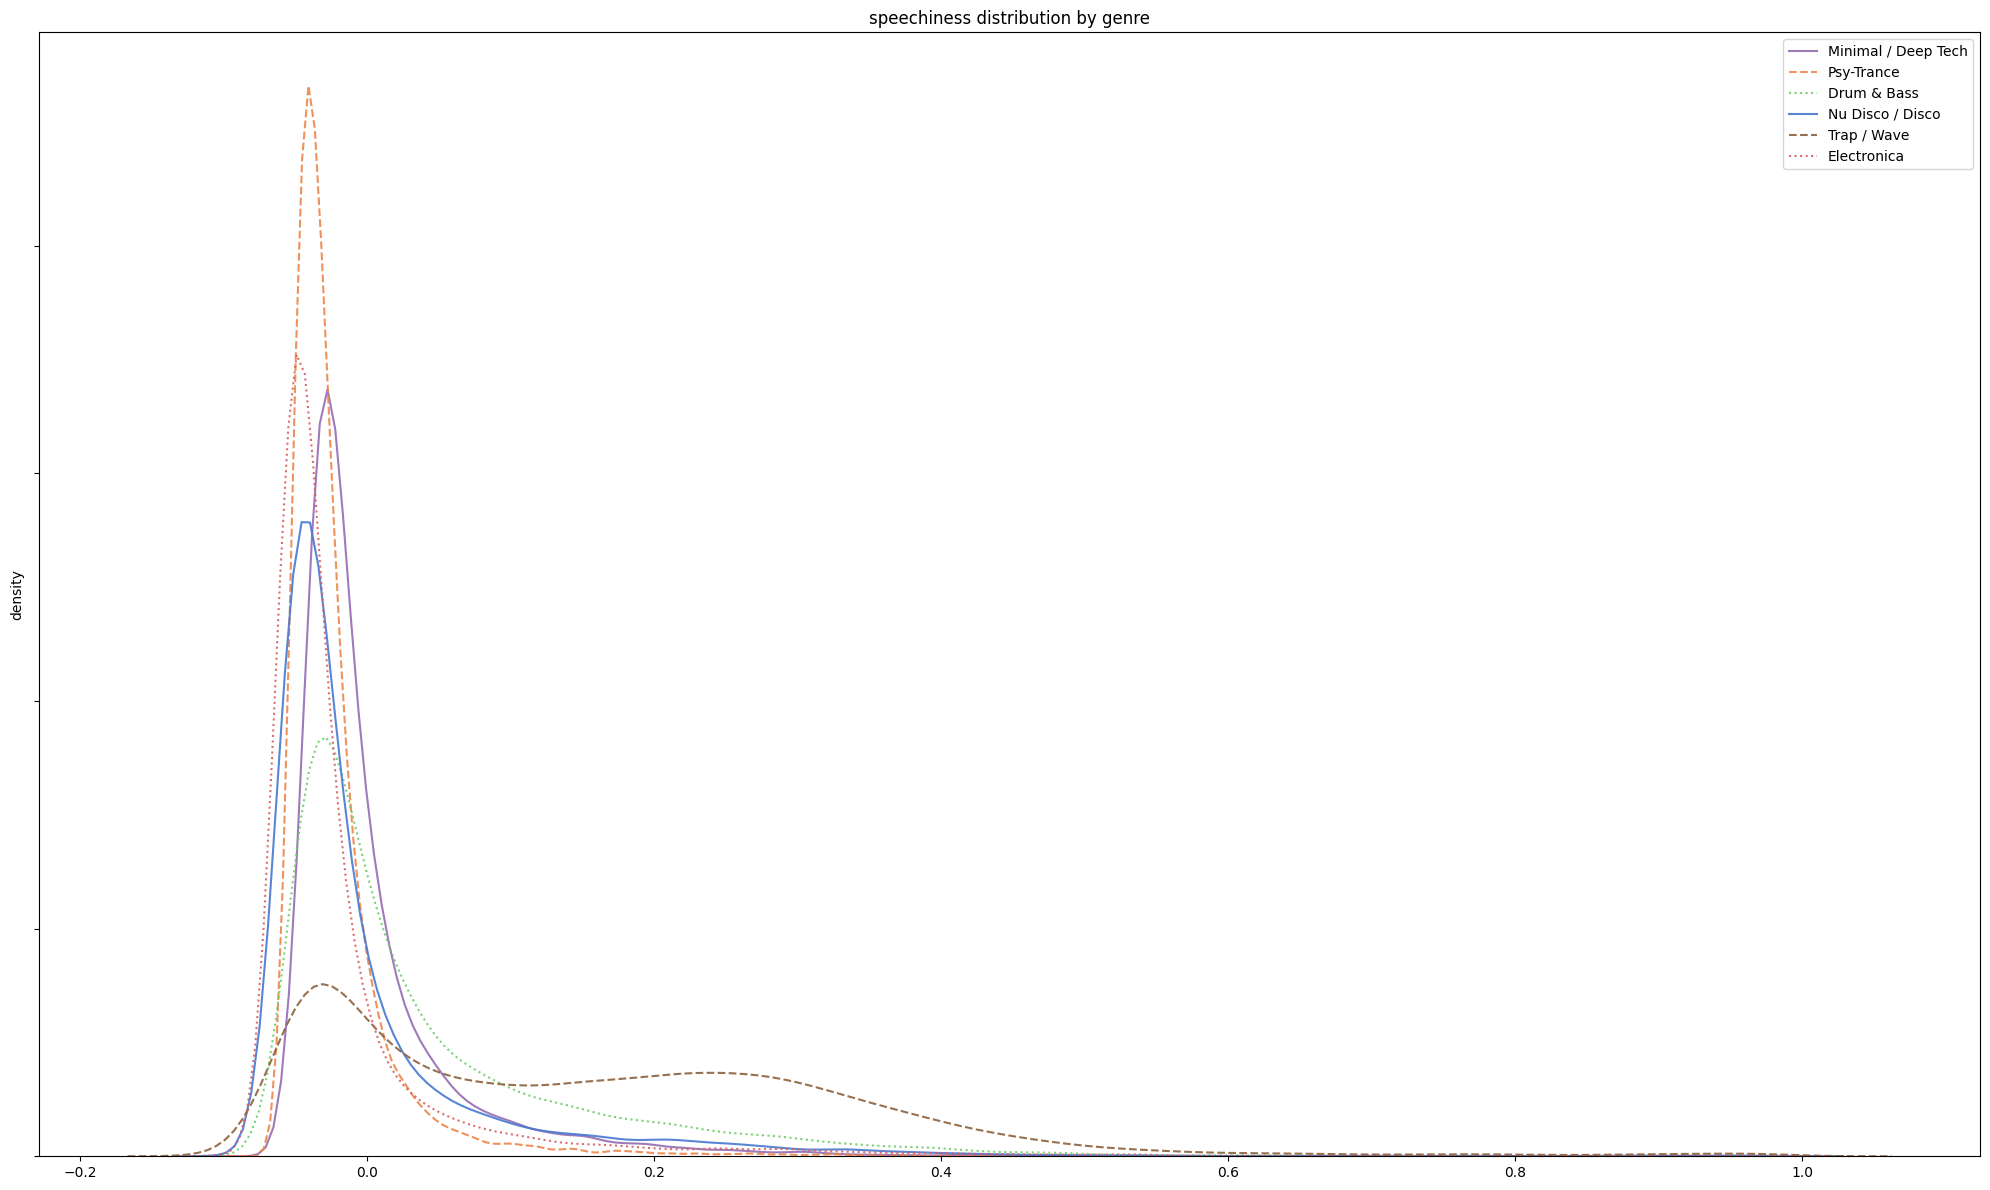

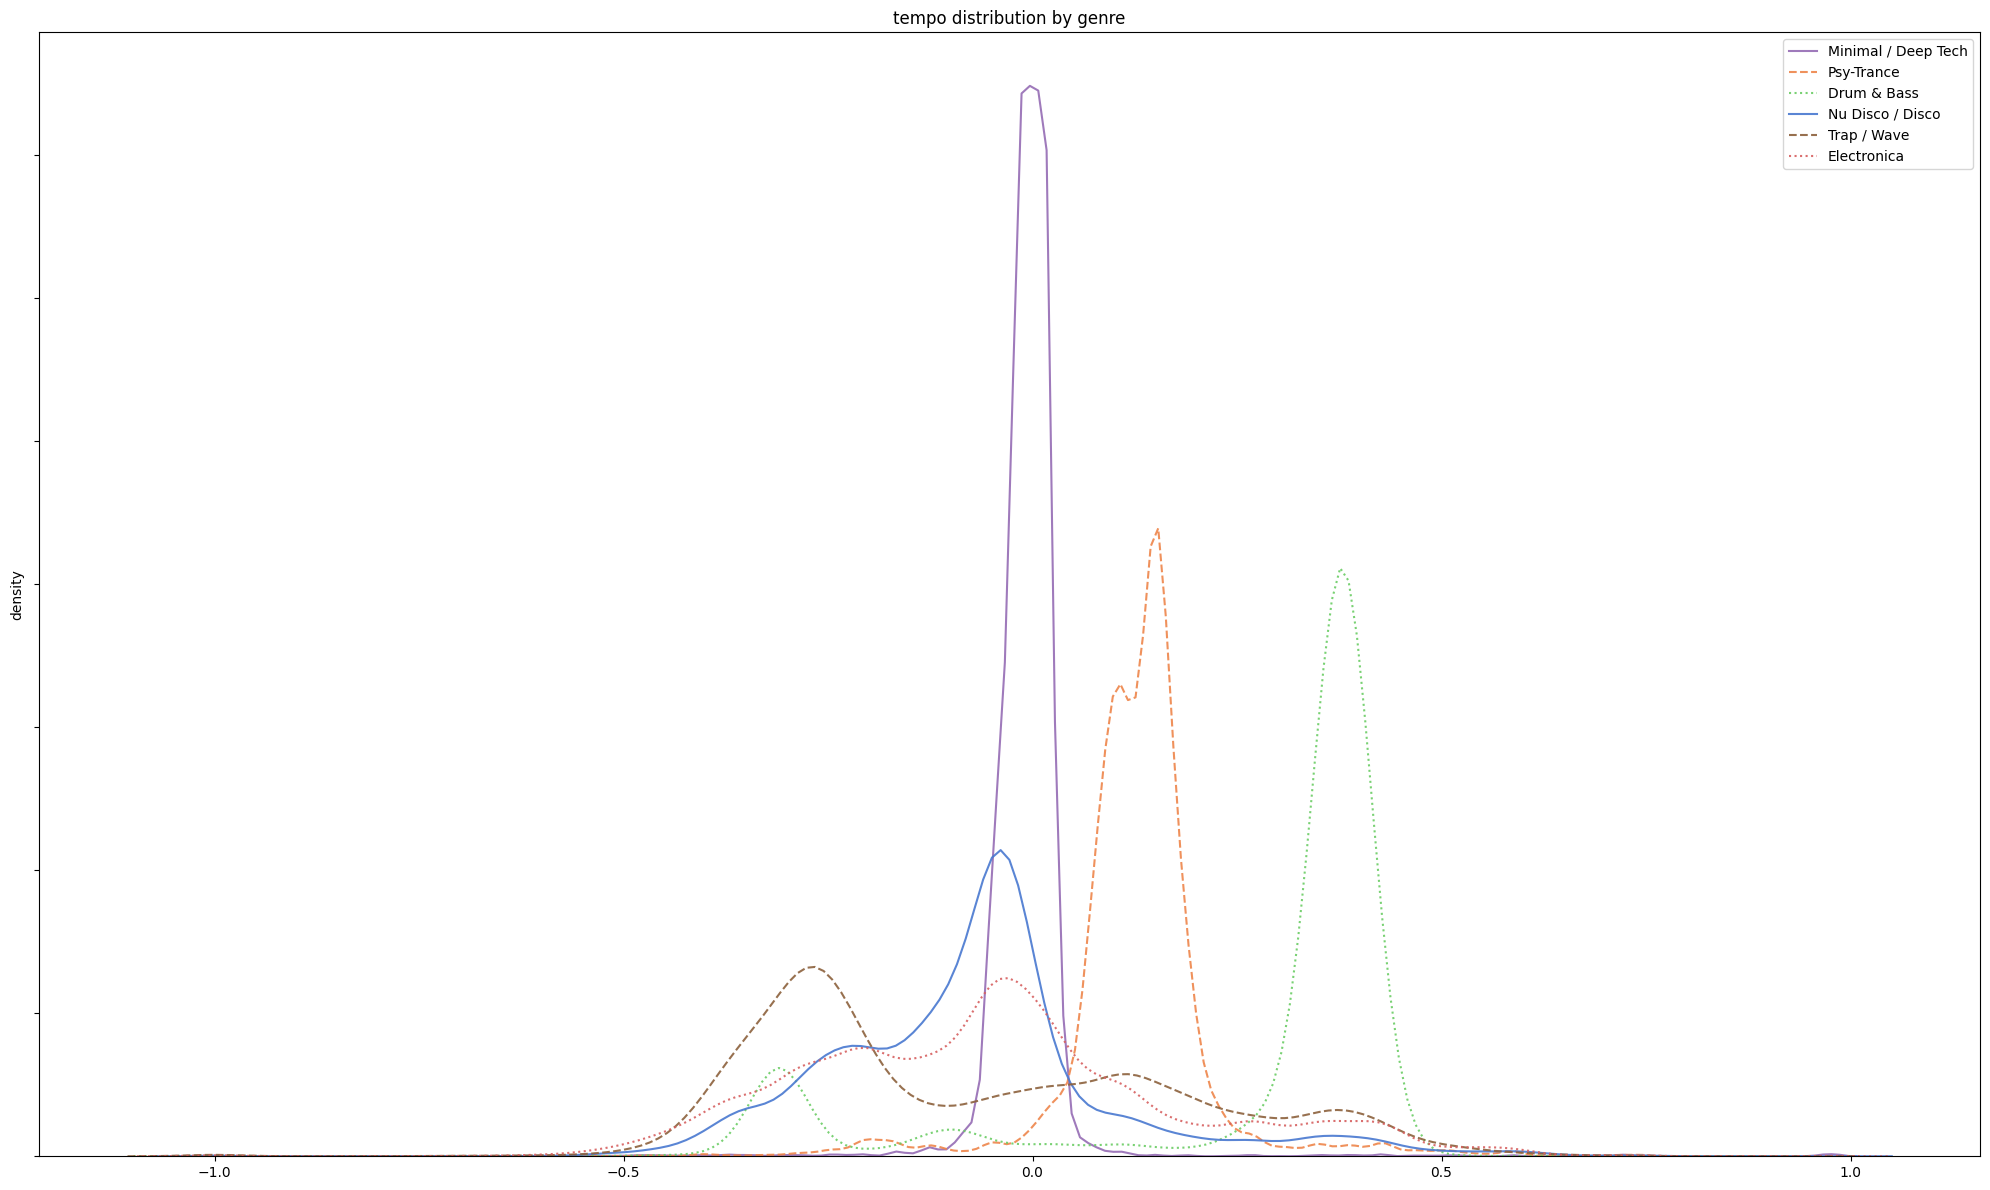

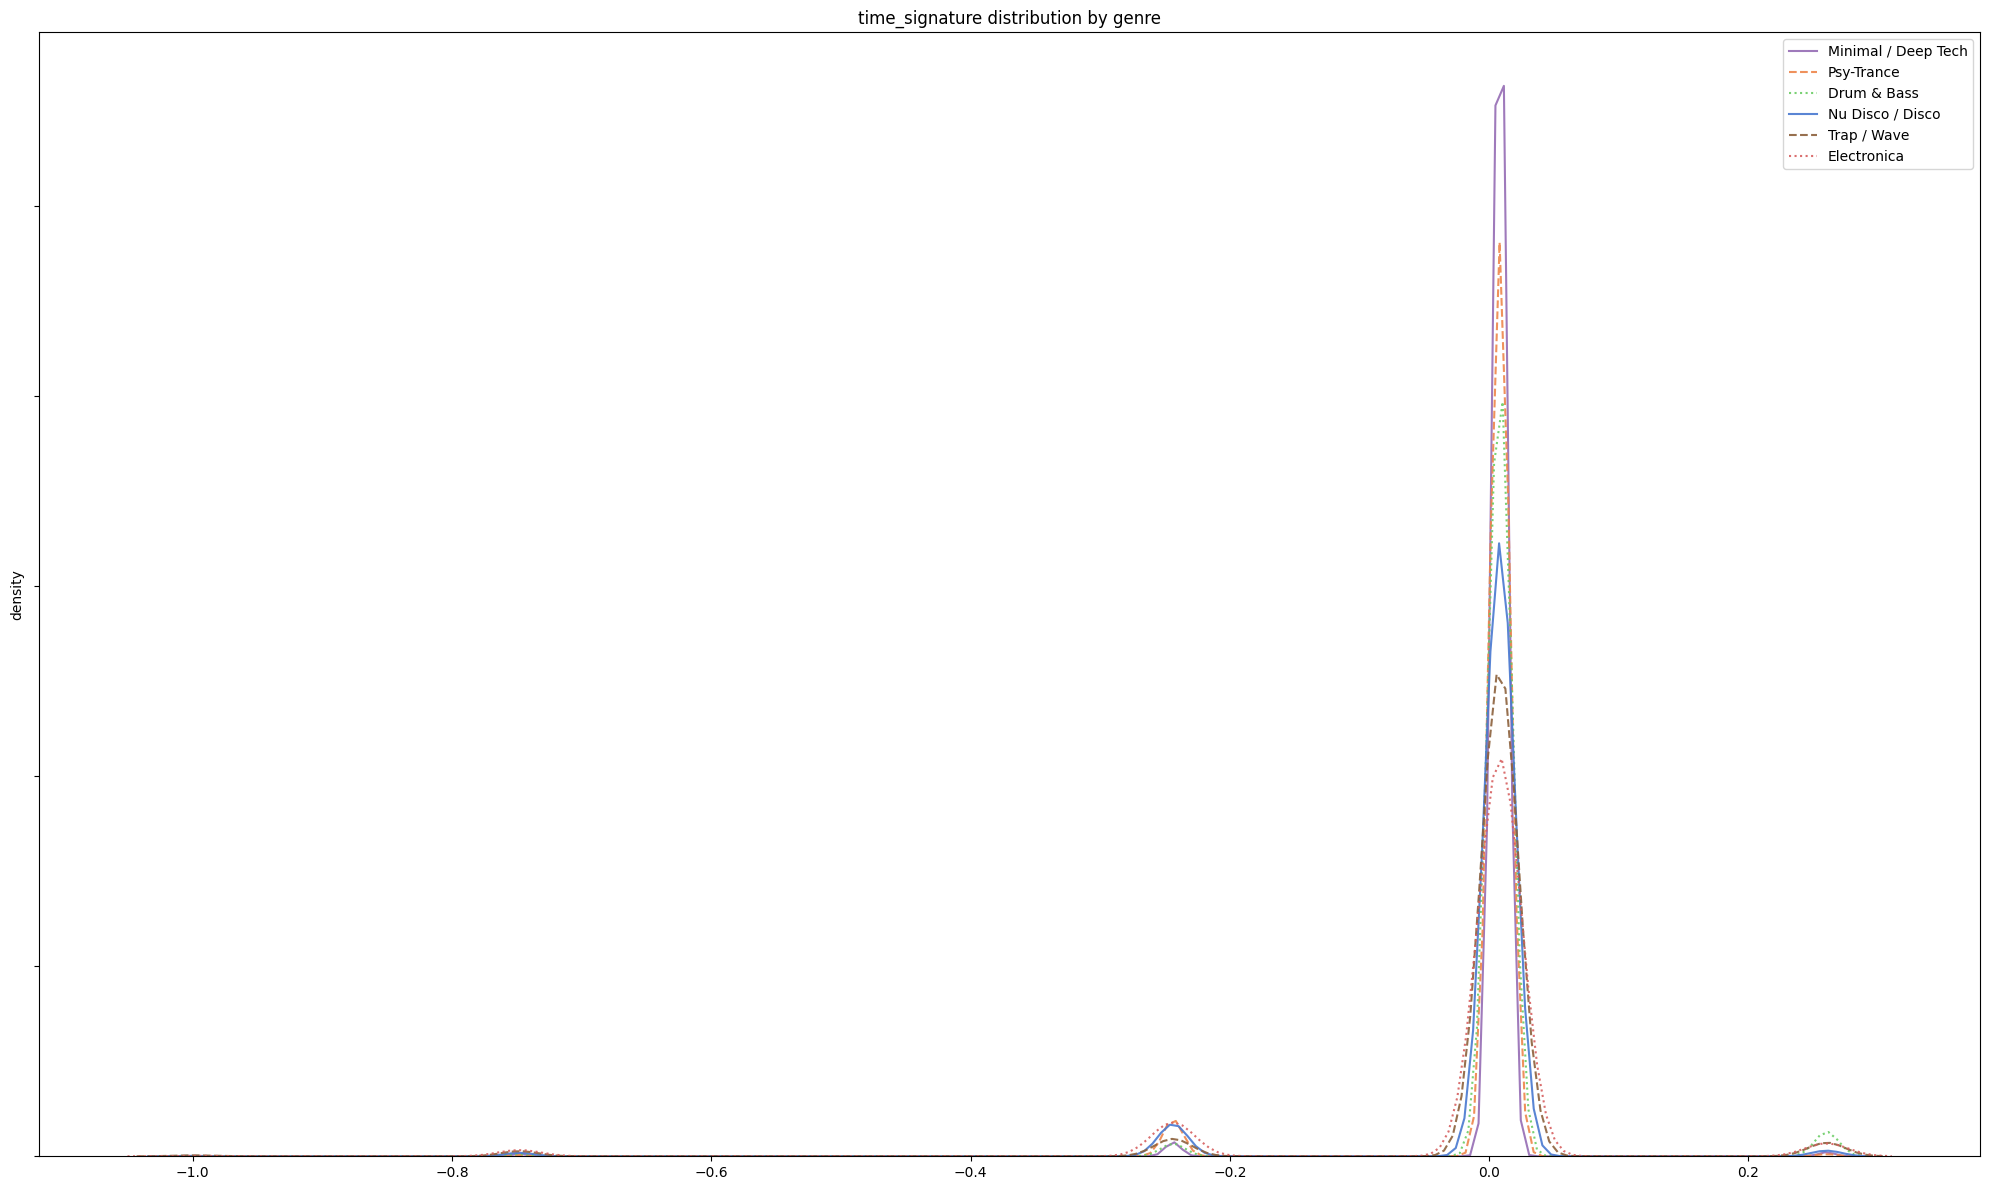

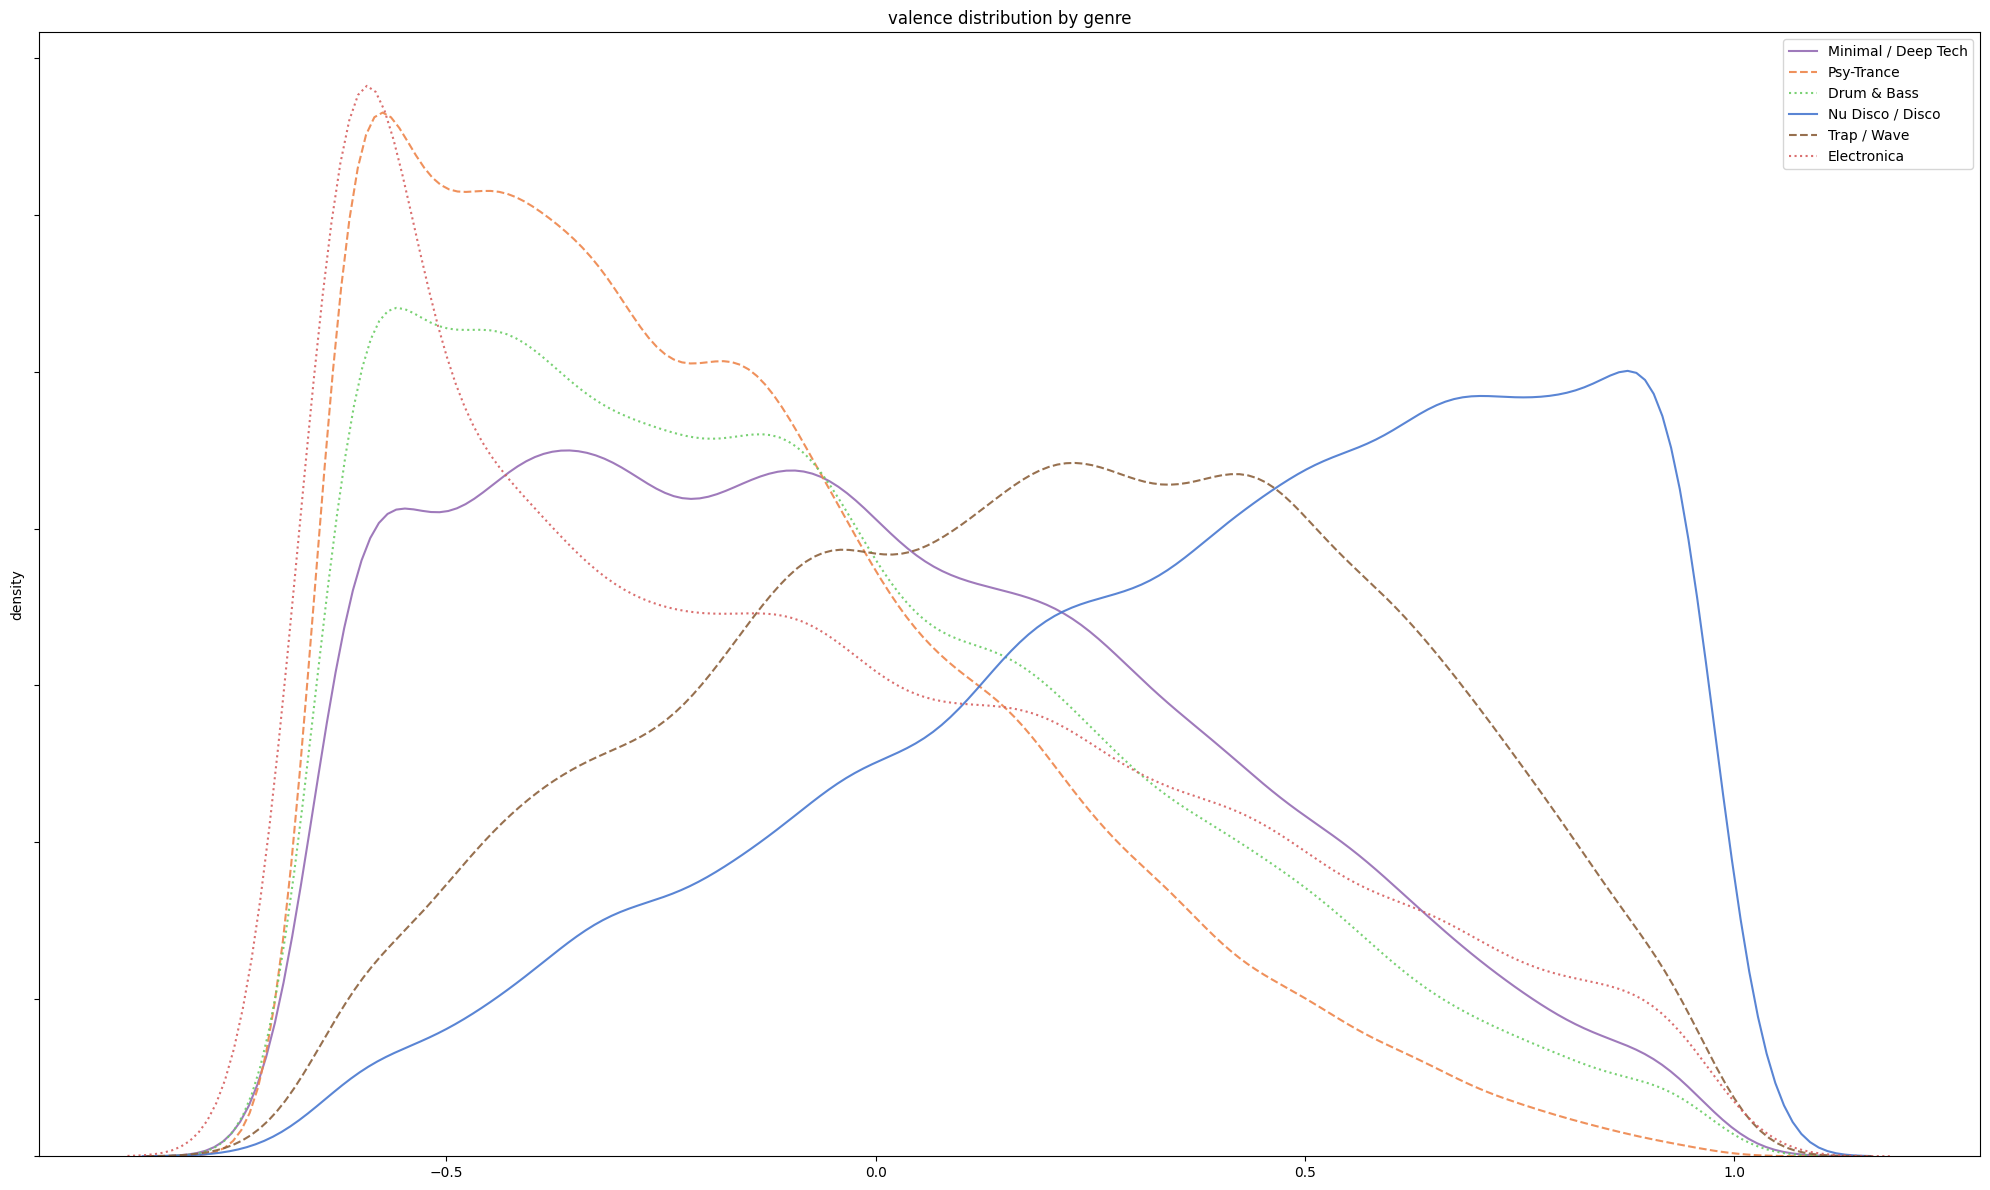

In [12]:

for feature in features:
    # Create a figure
    plt.figure(figsize=(20, 12))
    
    # Loop over distinct genres
    for index , (color , genre) in enumerate(zip(hex_colors ,selected_genres)):
        # Filter the DataFrame for the current genre
        genre_data = features_genre_df.filter(features_genre_df["genre"] == genre)
        
        # Extract the feature data for the current genre
        feature_data = genre_data.select(feature).rdd.flatMap(lambda x: x).collect()
        
        # Plot the KDE plot for the current genre
        lineType = "-"
        if index % 3 == 1:
            lineType = "--"
        elif index % 3 == 2:
            lineType = ":"
        sns.kdeplot(data=feature_data, alpha=0.9, common_norm=False, label=genre , color=color , linestyle=lineType)
    
    # Set title and labels
    plt.title(f"{feature} distribution by genre")
    plt.xlabel("")
    plt.ylabel("density")
    plt.gca().set_yticklabels([])
    
    # Show legend
    plt.legend()
    
    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

In [13]:
features_genre_df.write.csv("120k",header=True)